# Phân tích cảm xúc với LSTM


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd '/content/drive/My Drive/Sentiment'

/content/drive/My Drive/Sentiment


## Import các thư viện cần thiết

In [3]:
import os
import sys
import time
import datetime
import math

import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

## Dữ liệu huấn luyện

In [4]:
data_dir = os.getcwd()
save_dir = os.path.join(os.getcwd(), 'saved_models')

pd.options.display.max_colwidth = 1000
#Đọc file data.csv 
data_df = pd.read_csv(os.path.join(data_dir, 'data.csv'))
data_df.head()

,id,text,class
0,dee6dfc5,"Đến quán 2 lần thôi , rất là thích !\nQuán tuy nằm trong hẻm nhưng rất dễ tìm , quán rộng_rãi thoáng mát sạch_sẽ .\nNhân_viên phục_vụ nhiệt_tình , siêu dễ_thương .\nThực_đơn phong_phú đa_dạng , giá siêu rẻ .\nThức_ăn nêm nếm hợp_khẩu vị , ngon_miệng .\nDesert ngọt vừa , không quá ngấy , rất ngon .\nTrà sữa , uyên_ương thơm và đúng vị mình đã từng uống ở HongKong .\nNói_chung điểm 10 cho chất_lượng , thích quán lắm !",1
1,800813f5,Đến quán vào tối chủ_nhật . Có band hát . Khá ổn . Tuy_nhiên không_gian tầng 1 hơi hẹp . Ngồi cả ra vỉa_hè . Đồ uống ko ngon lămz,0
2,6553e47f,Phục_vụ lâu quá mặc_dù khách rất vắng .\nĐợi gần 15p mới mang được ly cà_phê ra . Ông này chỉ khéo quảng_bá chứ với mình chắc không quay lại_nữa .,0
3,b45a1ff1,"Ko gian bé_tí , quán chật_chội , đông người nên phục_vụ chưa tốt . Đồ uống bình_thường ( đặc_biệt khi so với giá_cả ) và ko có gì đặc_sắc cả .",0
4,f92694b0,"Khi mình order , đặt bánh thì nhận được sự tiếp_đãi , tư_vấn và nói_chuyện rất gần_gũi , rất nhiệt_tình .\nBánh thì rất tuyệt , nhân béo , rau_câu không dùng phẩm . Sau_này có dịp sinh_nhật , mình sẽ order mẫu lớn .\nChúc các bạn làm_ăn phát_đạt !",1


In [5]:
#Load dữ liệu từ 2 file *.npy vừa tạo được từ file CreateNPY.ipynb
words_list = np.load(os.path.join(data_dir, 'baomoi_word_list.npy'))
words_list = words_list.tolist()
print('Tập các từ đã tải')
words_vector = np.load(os.path.join(data_dir, 'baomoi_word_vector.npy'))
words_vector = np.float32(words_vector)
print ('Tập vector đã tải')

Tập các từ đã tải
Tập vector đã tải


In [6]:
#Tạo Dict: {word:index}
word2idx = {w:i for i,w in enumerate(words_list)}
print("Có ", len(word2idx), " từ trong từ điển vector")
print("Ví dụ index của từ \'yêu\' là: ", word2idx['yêu'])

Có  439056  từ trong từ điển vector
Ví dụ index của từ 'yêu' là:  346


In [ ]:
# Loại bỏ các dấu câu, dấu ngoặc, chấm than chấm hỏi, vân vân..., chỉ chừa lại các kí tự chữ và số
import re

strip_special_chars = re.compile("[^\w0-9 ]+")
def clean_sentences(string):
    #Hàm xử lý, loại bỏ đi những kí tự đặc biệt trả về các từ ở dạng viết thường
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

def get_sentence_indices(sentence, max_seq_length, _words_list):
    """
    Hàm này dùng để lấy index cho từng từ trong câu (không có dấu câu, có thể in hoa)
    ----------
    sentence: câu cần xử lý
    max_seq_length: giới hạn số từ tối đa trong câu
    _words_list: bản sao local của words_list, được truyền vào hàm
    ----------
    """
    indices = np.zeros((max_seq_length), dtype='int32')
    
    # Tách câu thành từng tiếng
    words = [word.lower() for word in sentence.split()]
    # Các từ không có trong câu đều không có trong words_list được gán chỉ số của 'unk' 
    unk_idx = word2idx['unk']
    for idx, word in enumerate(words[:max_seq_length]):
      try:
        indices[idx] = word2idx[word]
      except:
        indices[idx] = unk_idx
        
    return indices

def text2indices(data_frame, max_length, _word_list):
    """
    Biến đổi các text trong dataframe thành ma trận index
    ----------
    data_frame: dataframe
        data frame chứa các text cần biến đổi
    max_length: int
        độ dài tối đa của một text
    _word_list: numpy.array
        array chứa các từ 
    ----------
    numpy.array
        len(data_frame) x max_length contains indices of text
    """
    indices = np.zeros((len(data_frame), max_length), dtype='int32')
    for idx, text in enumerate(tqdm(data_frame['text'])):
        indices[idx,:] = get_sentence_indices(clean_sentences(text), max_length, _word_list)
    return indices

## Khảo sát dữ liệu huấn luyện

Với khối lượng dữ liệu lớn (27,000 mẫu), nếu chúng ta chọn đặt giới hạn số từ tối đa cho một câu (MAX_SEQ_LENGTH) quá cao thì sẽ phí bộ nhớ khi biểu diễn những câu review quá ngắn. Ngược lại, nếu đặt giới hạn quá thấp thì ở những câu dài, ta sẽ bị mất các từ cuối, có khả năng ảnh hưởng đến việc suy đoán cảm xúc.

Vì vậy, ta cần thống kê độ dài của các mẫu dữ liệu huấn luyện.

In [8]:
num_words = [len(clean_sentences(x).split()) for x in list(data_df['text'])]
print('The total number of samples is', len(data_df))
print('The total number of words in the files is', sum(num_words))
print('The average number of words in the files is', sum(num_words)/len(num_words))

The total number of samples is 27000
The total number of words in the files is 2252760
The average number of words in the files is 83.43555555555555


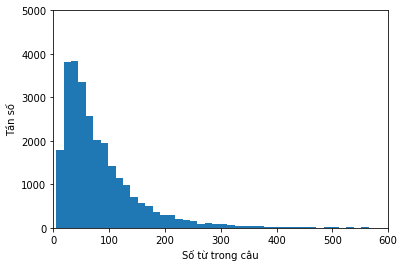

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(num_words, 100)
plt.xlabel('Số từ trong câu')
plt.ylabel('Tần số')
plt.axis([0, 600, 0, 5000])
plt.show()

Từ biểu đồ trên ta chọn số số từ trong mỗi câu tối đa khoảng 200 từ

In [ ]:
MAX_SEQ_LENGTH = 200

In [11]:
#Chuyển dữ liệu vào thành ma trận chỉ sổ train_ids
data_ids = text2indices(data_df, MAX_SEQ_LENGTH, words_list)
np.save('data_ids.npy', data_ids)
data_ids = np.load('data_ids.npy')
data_ids.shape

100%|██████████| 27000/27000 [00:02<00:00, 11184.84it/s]


(27000, 200)

# **Chuẩn bị huấn luyện**

Chia dữ liệu huấn luyện trong tập data chia thành các tập: train:validation:test = 8:1:1

In [ ]:
#Chia dữ liệu huấn luyện thành 3 tập train:validation:test = 8:1:1
train_x, test_validation_x, train_y, test_validation_y  = train_test_split(data_ids, data_df['class'], test_size=0.2, random_state=2019)
validation_x, test_x, validation_y, test_y = train_test_split(test_validation_x, test_validation_y, test_size=0.5, random_state=2018)
#Chuyển ma trận chỉ số thành ma trận vector 
train_x = tf.nn.embedding_lookup(words_vector, train_x)
validation_x = tf.nn.embedding_lookup(words_vector, validation_x)
test_x = tf.nn.embedding_lookup(words_vector, test_x)

In [13]:
#Định dạng ma trận vector về numpy.array
_train_x = tf.Session().run(train_x)
_validation_x = tf.Session().run(validation_x)
_test_x = tf.Session().run(test_x)
print("Đã định dạng về dạng nummpy.array")

Đã định dạng về dạng nummpy.array


# **Xây dựng model RNN**

In [14]:
import math
import numpy
import matplotlib.pyplot as plt
import keras
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, LSTM, GRU, CuDNNLSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import load_model

LSTM_UNIT = 128
DR_RATE = 0.3
BATCH_SIZE = 128
EPOCHS = 20

model = Sequential()

model.add(Bidirectional(LSTM(128, return_sequences=True),
                        input_shape=(200, 400)))
model.add(Dropout(0.3))

model.add(Bidirectional(LSTM(128, return_sequences=False)))
                        
model.add(Dropout(0.3))


model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Using TensorFlow backend.



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 200, 256)          541696    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 256)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
________________________________________

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print('Train...')
History = model.fit(_train_x, train_y,
                    batch_size=128,
                    epochs=20,
                    validation_data = (_validation_x, validation_y)
                     )

Train...


Train on 21600 samples, validate on 2700 samples
Epoch 1/20





  640/21600 [..............................] - ETA: 5:45 - loss: 0.6848 - acc: 0.5547

In [ ]:
scores = model.evaluate(_test_x, test_y, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

In [ ]:
model_name = 'model-{epoch:20}-{val_acc:0.8844}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

In [ ]:
#Visualize quá trình luyện dữ liệu 
fig = plt.figure()
maxEpochs = 20
plt.plot(np.arange(0, maxEpochs), History.history['loss'], label='training loss')
plt.plot(np.arange(0, maxEpochs), History.history['val_loss'], label='validation loss')
plt.plot(np.arange(0, maxEpochs), History.history['acc'], label='training accuracy')
plt.plot(np.arange(0, maxEpochs), History.history['val_acc'], label='validation accuracy')
plt.title('Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss|Accuracy')
plt.legend()

In [ ]:
#Hàm đoán cảm xúc bình luận
def predict_sentence(model, sentence, thres_hold = 0.5):
  indices_sen = get_sentence_indices(sentence, max_seq_length=200, _words_list=words_list)
  ids2vec_sen = tf.nn.embedding_lookup(words_vector, indices_sen)
  _vec_sen = tf.Session().run(ids2vec_sen)
  _vec_sen=np.array([_vec_sen])
  pred = model.predict(_vec_sen)[0][0]

  if 0 < pred <= thres_hold:
    print('NEGATIVE')
  else: 
    print('POSITIVE')
  print(pred)

In [ ]:
#Đoán thử một vài câu 
my_model = load_model(model_path)
predict_sentence(my_model, sentence="Mình và người yêu đã đến đây cách đây 2 năm, trà sữa vẫn ngon như ngày nào")